**Эксперимент 1**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import os

from torchsummary import summary
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Подключение GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

На первом шаге я конструирую маленькую модель для последующего его обучения без привлечения большой модели


In [3]:
#Загрузка данных для первого эксперимента - обучение маленькой модели без привлечения большой модели
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
!gzip -d imagewoof2-160.tgz
!tar -xvf imagewoof2-160.tar

Выходные данные были обрезаны до нескольких последних строк (5000).
imagewoof2-160/train/n02111889/n02111889_2643.JPEG
imagewoof2-160/train/n02111889/n02111889_14108.JPEG
imagewoof2-160/train/n02111889/n02111889_259.JPEG
imagewoof2-160/train/n02111889/n02111889_4237.JPEG
imagewoof2-160/train/n02111889/n02111889_5778.JPEG
imagewoof2-160/train/n02111889/n02111889_6356.JPEG
imagewoof2-160/train/n02111889/n02111889_8728.JPEG
imagewoof2-160/train/n02111889/n02111889_5679.JPEG
imagewoof2-160/train/n02111889/n02111889_9018.JPEG
imagewoof2-160/train/n02111889/n02111889_3146.JPEG
imagewoof2-160/train/n02111889/n02111889_5567.JPEG
imagewoof2-160/train/n02111889/n02111889_15505.JPEG
imagewoof2-160/train/n02111889/n02111889_15719.JPEG
imagewoof2-160/train/n02111889/n02111889_2944.JPEG
imagewoof2-160/train/n02111889/n02111889_11487.JPEG
imagewoof2-160/train/n02111889/n02111889_2867.JPEG
imagewoof2-160/train/n02111889/n02111889_12879.JPEG
imagewoof2-160/train/n02111889/n02111889_5968.JPEG
imagewoof2

In [4]:
#Каждая папка из загруженных файлов - отдельная метка класса, нумеруем их от 0 до 9, чтобы потом использовать многоклассовую классификацию
#train
from PIL import Image
images_train = []
labels_train = []
folderNames = ["n02086240", "n02087394", "n02088364", "n02089973", "n02093754", "n02096294", "n02099601", "n02105641", "n02111889", "n02115641"]
y = 0
for folderName in folderNames:
  for root, dirs, files in os.walk("imagewoof2-160/train/" + folderName, 
                                  topdown=False):
    for name in files:
      img = Image.open(os.path.join(root, name)).resize((160, 160)) # открываем картинку и меняем размер на (160,160)
      img = np.array(img)
      if (len(img.shape) < 3): #Здесь оставляем только один канал у каждой картинки, это ускоряет обучение 
        images_train.append(img.reshape((1, 160, 160)))
      else:
        images_train.append(img[:,:,0].reshape((1, 160, 160)))
      labels_train.append(y)
  y = y + 1

In [5]:
#val 
images_val = []
labels_val = []
folderNames = ["n02086240", "n02087394", "n02088364", "n02089973", "n02093754", "n02096294", "n02099601", "n02105641", "n02111889", "n02115641"]
y = 0
for folderName in folderNames:
  for root, dirs, files in os.walk("imagewoof2-160/val/" + folderName, 
                                  topdown=False):
    for name in files:
      img = Image.open(os.path.join(root, name)).resize((160, 160))
      img = np.array(img)
      if (len(img.shape) < 3):
        images_val.append(img.reshape((1, 160, 160)))
      else:
        images_val.append(img[:,:,0].reshape((1, 160, 160)))
      labels_val.append(y)
  y = y + 1

In [6]:
# Некоторая предобработка датасета, чтобы корректно использовать функцию torch.utils.data.DataLoader - формирование батчевого датасета
images_train = np.array(images_train)
labels_train = np.array(labels_train).reshape(-1,1)
dataset = []
for i in range(len(images_train)):
  dataset.append((images_train[i], labels_train[i]))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=60, shuffle= True)

In [7]:
# Формирование датасета для тестирования модели
images_val = np.array(images_val)
labels_val = np.array(labels_val).reshape(-1,1)
dataset_val = []
for i in range(len(images_val)):
  dataset_val.append((images_val[i], labels_val[i]))
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=250, shuffle= True)

In [8]:
import math
import torch
import random
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [9]:
#Как раз класс формирования маленькой модели - distilled model
class distilledModel(nn.Module):
    def __init__(self, width = 160, height = 160, channels = 1, classes = 10):
        super(distilledModel, self).__init__()

        self.width, self.height, self.channels = width, height, channels
        self.input_shape = (height, width, channels)
        self.classes = classes

        # Список использующихся слоев 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding= 0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 0)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding= 0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding= 0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding= 0)
        self.batch1 = nn.BatchNorm2d(32)
        self.batch5 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(256)
        self.batch6 = nn.BatchNorm2d(512)
        self.batch3 = nn.BatchNorm1d(512)
        self.batch4 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.linear2 = nn.Linear(in_features = 4608, out_features=512)
        self.linear3 = nn.Linear(in_features = 512,out_features=128)
        self.out = nn.Linear(in_features = 128,out_features=10)
    
  
    def feature_extractor(self, inp):

        # conv1
        t = self.conv1(inp)
        t = F.relu(t)
        t = self.batch1(t)
        t = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))(t)
        t = self.dropout1(t)


        # conv2
        t = self.conv2(t)
        t = F.relu(t)
        t = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))(t)
        t = self.batch5(t)
        t = self.dropout1(t)


        # conv3
        t = self.conv3(t)
        t = F.relu(t)
        t = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))(t)
        t = self.dropout1(t)


        # conv4
        t = self.conv4(t)
        t = F.relu(t)
        t = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))(t)
        t = self.batch2(t)
        t = self.dropout1(t)


        #conv5
        t = self.conv5(t)
        t = F.relu(t)
        t = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))(t)
        t = self.batch6(t)
        t = self.dropout1(t)

        
        #Flatten
        output = self.flatten(t)

        return output

    def classifier(self, inp):

        t = self.linear2(inp)
        t = F.relu(t)
        t = self.batch3(t)
        t = self.dropout2(t)
        t = self.linear3(t)
        t = F.relu(t)
        t = self.batch4(t)
        t = self.dropout2(t)

        output = self.out(t)

        return output


    def forward(self, input):

        feature_output = self.feature_extractor(input)

        classifier_output = self.classifier(feature_output)

        return classifier_output           


In [10]:
model = distilledModel(width = 160, height = 160, channels = 1, classes = 10)

lr=0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

distilledModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2

In [11]:
test = next(iter(val_loader)) # Для формирования валидационной и тестовой выборки - там 250 картинок и ответов к ним в батче

In [13]:
# Тренировка

losses = []
num_epoch = 50
i = 0
test_x = test[0].to(device = device, dtype=torch.float)
test_y = torch.squeeze(test[1], 1)
test_y = test_y.to(device)
for epoch_num in tqdm.tnrange(num_epoch):
    model.train()
    for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
        i += 1
        batch_x = batch_x.to(device = device, dtype=torch.float)
        batch_label = torch.squeeze(batch_label, 1)
        batch_label = batch_label.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 500 == 0:
          model.eval()
          outputs_test = model(test_x)
          max_test = torch.max(outputs_test, 1).indices

          accuracy_test = np.true_divide((test_y == max_test).sum().cpu(), max_test.shape)*100 

          print("accuracy on val: ", accuracy_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


accuracy on val:  tensor([54.4000], dtype=torch.float64)


accuracy on val:  tensor([51.6000], dtype=torch.float64)


accuracy on val:  tensor([52.4000], dtype=torch.float64)


accuracy on val:  tensor([48.], dtype=torch.float64)


accuracy on val:  tensor([54.], dtype=torch.float64)


accuracy on val:  tensor([49.2000], dtype=torch.float64)


accuracy on val:  tensor([50.], dtype=torch.float64)


accuracy on val:  tensor([54.], dtype=torch.float64)


accuracy on val:  tensor([46.8000], dtype=torch.float64)


accuracy on val:  tensor([52.], dtype=torch.float64)


accuracy on val:  tensor([54.4000], dtype=torch.float64)


accuracy on val:  tensor([50.4000], dtype=torch.float64)


accuracy on val:  tensor([53.6000], dtype=torch.float64)


accuracy on val:  tensor([52.4000], dtype=torch.float64)


accuracy on val:  tensor([56.0000], dtype=torch.float64)



In [14]:
# Тест обученной модели на тестовых данных

test = next(iter(val_loader))
test_x = test[0].to(device = device, dtype=torch.float)
test_y = torch.squeeze(test[1], 1)
test_y = test_y.to(device)

outputs_test = model(test_x)
max_test = torch.max(outputs_test, 1).indices
accuracy_test = np.true_divide((test_y == max_test).sum().cpu(), max_test.shape)*100 

print("accuracy on test: ", accuracy_test)

accuracy on test:  tensor([57.6000], dtype=torch.float64)


Как мы видим, качество достигло 57.6%

P.S. Под качеством здесь и везде далее понимается метрика Достоверность (accuracy) - отношение числа правильно классифицируемых картинок к общему числу тестовых картинок. 

Я обращу ваше внимание, что в этой модели мы используем только 1 входной канал, но вообще то у картинки 3 канала. Для более правильного и качественного обучения я загружаю библиотеку fatai - она как раз используется для обучения нейронных моделей и хорошо совместима с датасетом imagewoof. Здесь я использую ту же модель, но уже с количеством входных каналов изображения - 3. А в остальном все слои и параметры аналогичны.  

То есть я провожу такое же обучение как и в первом случае, но уже с помощью библиотеки fatai.

In [15]:
from fastai.vision import *

import warnings
warnings.filterwarnings("ignore") # Могут вылезать навязчивые ворнинги, не показываем их

In [16]:
path = URLs.IMAGEWOOF 
path = untar_data(path)

batch=64
data = (ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(([flip_lr(p=0.5)], []), size=160).databunch(bs=batch, num_workers=1).presize(160, scale=(0.35,1)).normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (9025 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n02088364,n02088364,n02088364,n02088364,n02088364
Path: /root/.fastai/data/imagewoof2;

Valid: LabelList (3929 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n02088364,n02088364,n02088364,n02088364,n02088364
Path: /root/.fastai/data/imagewoof2;

Test: None

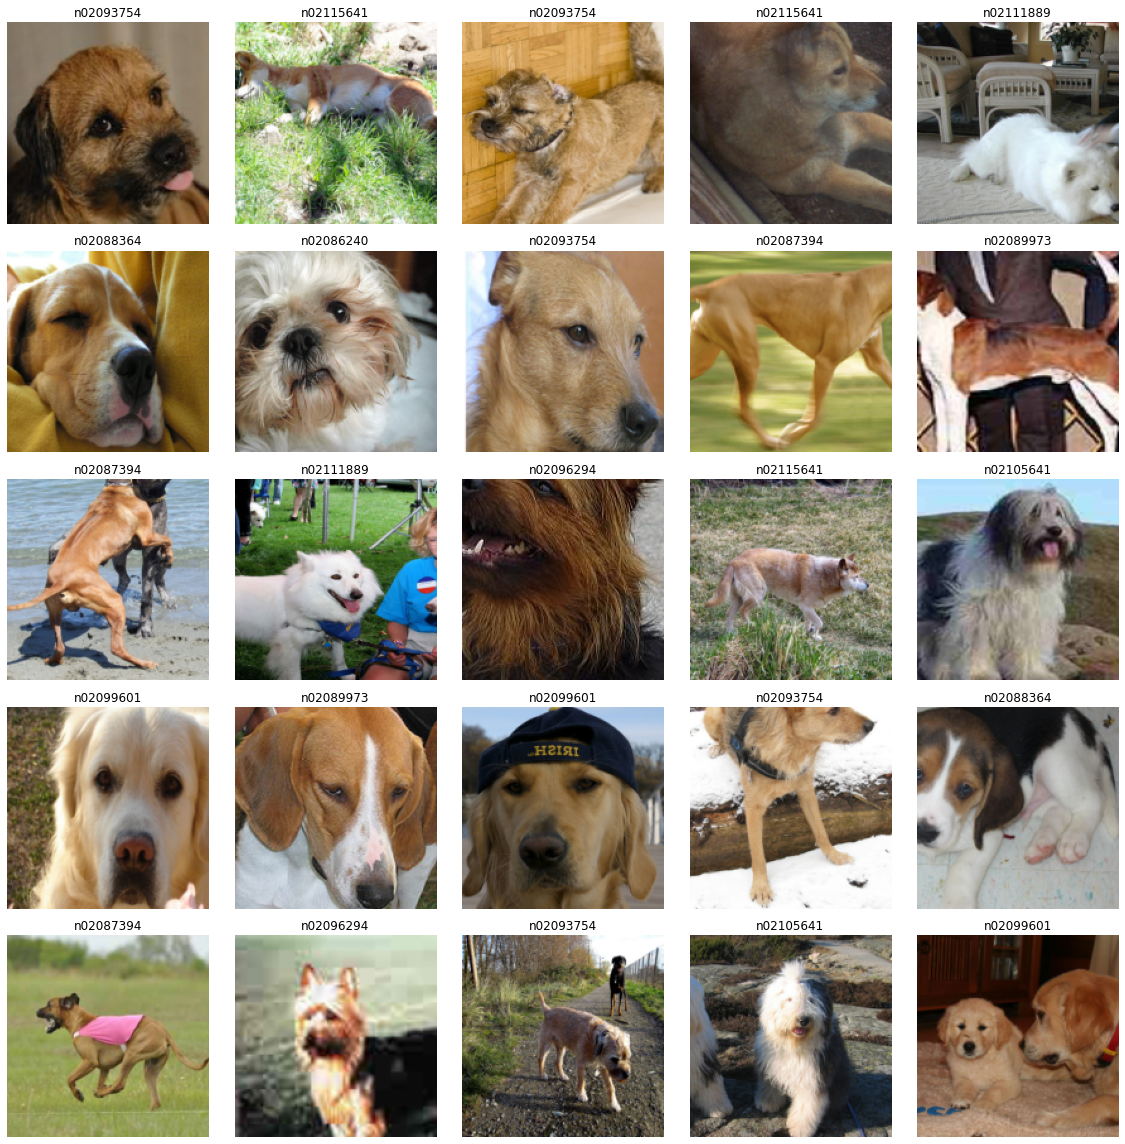

In [ ]:
# Покажем какие вообще картинки

data.show_batch(5, figsize=(16,16))

In [ ]:
#  Маленькая модель - distilled model

distilledModelSequential = nn.Sequential(
    
   nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
   nn.ReLU(), 
   nn.BatchNorm2d(32),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.BatchNorm2d(64),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(256),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(512),
   nn.Dropout(0.25),

   nn.Flatten(),

   nn.Linear(in_features = 4608, out_features=512),
   nn.ReLU(),
   nn.BatchNorm1d(512),
   nn.Dropout(0.5),

   nn.Linear(in_features = 512,out_features=128),
   nn.ReLU(),
   nn.BatchNorm1d(128),
   nn.Dropout(0.5),

   nn.Linear(in_features = 128,out_features=10)
)

In [ ]:
def init_weights(m): # случайная инициализация весов
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
distilledModelSequential.apply(init_weights)
distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy])) # создание модели Learner с помощью fastai

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


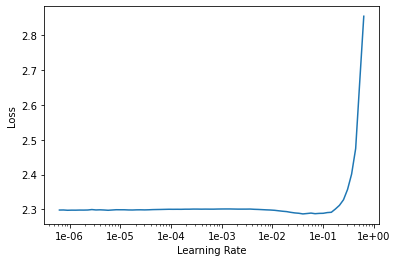

In [ ]:
distilledModelLearn.lr_find()  # поиск максимального шага обучения
distilledModelLearn.recorder.plot()

In [ ]:
distilledModelLearn.fit_one_cycle(30, 5e-3) # непосредственное обучение на 30 эпохах

Как мы видим, точность достагла значения 70%. Что больше чем в первом случае - это можно объяснить тем, что в этот раз использовались все каналы входного изображения и информация не потерялась. С этого момента под результатом обучения этой сконструированной маленькой модели будем понимать эту вторую достоверность 70%

Далее как и говорилось вначале, я формирую известную модель Le-Net5 и также обучаю ее (она также играет роль маленькой модели - те в моем эксперименте две разные маленькие модели и для каждой я провожу эксперименты).

In [ ]:
class Le_Net5(nn.Module):
    def __init__(self):
        super(Le_Net5, self).__init__()

        # Список слоев использующихся
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5, 5))

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=(4, 4), stride=4)

        self.linear = nn.Linear(1920, 84)
        self.out = nn.Linear(84, 10)
      
    
  
    def Conv1(self, inp):

        t = self.conv1(inp)
        t = self.relu(t)
        t = self.max_pool(t)

        return t

    def Conv2(self, inp):

        t = self.conv2(inp)
        t = self.relu(t)
        t = self.max_pool(t)

        return t

    def Conv3(self, inp):

        t = self.conv3(inp)
        t = self.relu(t)

        return t
    
    def Linear(self, inp):

      t = self.linear(inp)
      t = self.relu(t)

      return t

    def output(self, inp):

      t = self.out(inp)
      
      return t

    def forward(self, input):

        out = self.Conv1(input)

        x = self.Conv2(out)
        out = self.Conv2(out)

        out += x

        out = self.Conv3(out)

        out = out.view(input.size(0), -1)

        out = self.Linear(out)

        output = self.output(out)

        return output      

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

distilled_model = Le_Net5()

        
distilled_model.apply(init_weights)
distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy])) # создание модели с помощью fastai

In [ ]:
distilledModelLearnLeNet.fit_one_cycle(30, 5e-3)

Для данной модели качество составило 52%. Меньше чем для ранее расмотренной модели - из за того, что эта более маленькая и имеет меньше параметров. 



Теперь попробуем подсоединить к 
обучению большую модель и использовать ее выходы как лэйблы для маленькой 

**Эксперимент 2**





А теперь давайте загрузим большую модель resnet50 с предобученными слоями, дообучим эту модель непосредственно на нашей выборке, а потом используем ее как большую модель, т.е. ее выход будет target label, а реальные ответы будут - hard label

Для этого используем библиотеку fastai - в ней удобно загружать существующие большие обученные модели и удобно работать с датасетом imagewoof

In [ ]:
from fastai.vision import *

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import os

from torchsummary import summary
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # Могут вылезать навязчивые ворнинги, не показываем их

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
# Тут получение пути до датасета и его загрузка
path = URLs.IMAGEWOOF 
path = untar_data(path)

batch=64
data = (ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(([flip_lr(p=0.5)], []), size=160).databunch(bs=batch, num_workers=1).presize(160, scale=(0.35,1)).normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (9025 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n02088364,n02088364,n02088364,n02088364,n02088364
Path: /root/.fastai/data/imagewoof2;

Valid: LabelList (3929 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n02088364,n02088364,n02088364,n02088364,n02088364
Path: /root/.fastai/data/imagewoof2;

Test: None

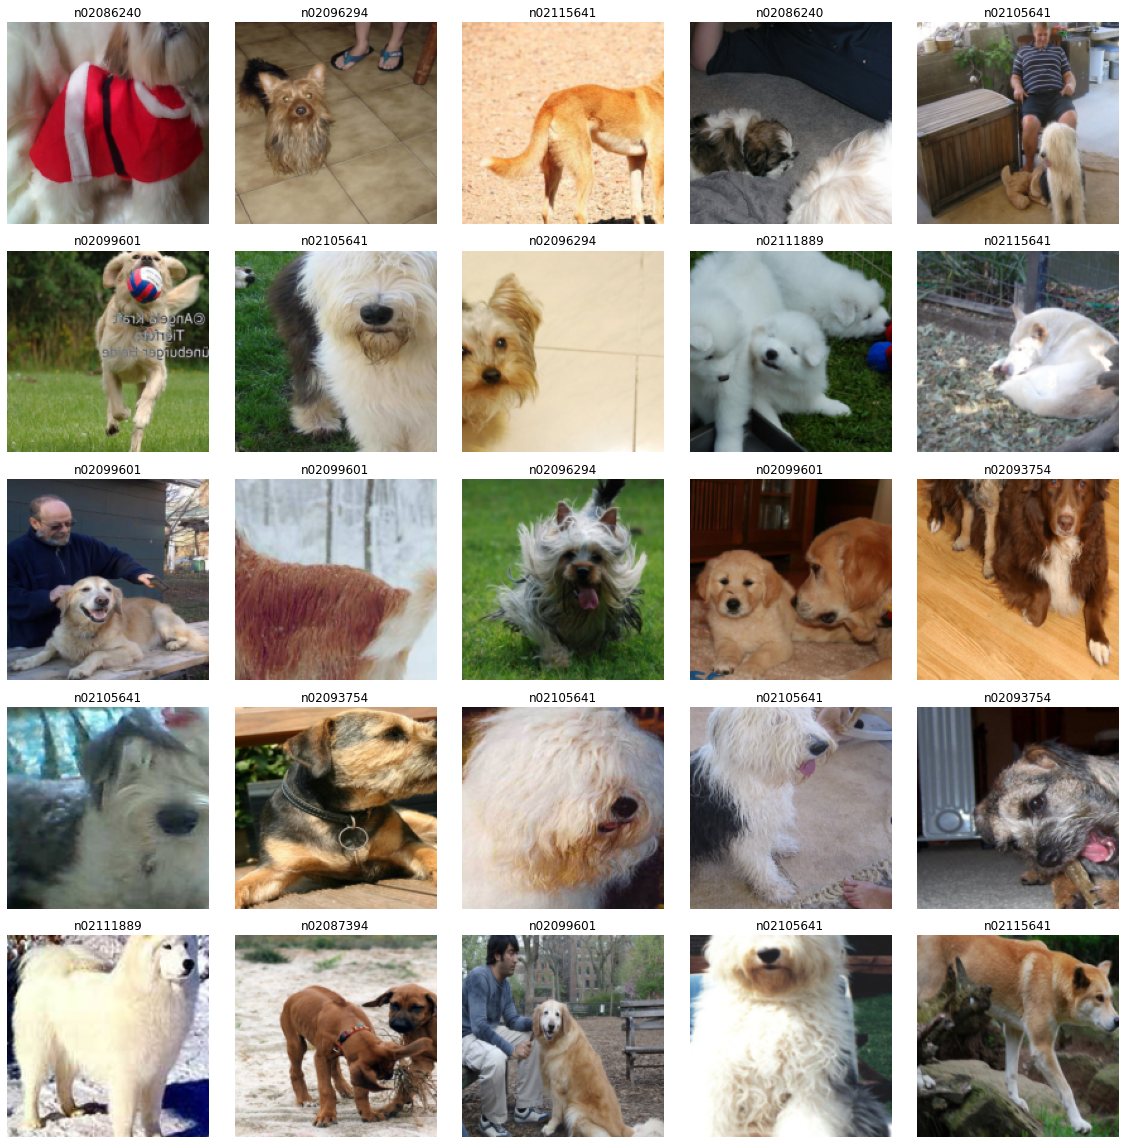

In [ ]:
# Покажем какие вообще картинки

data.show_batch(5, figsize=(16,16))

In [ ]:
# Формируем большую модель из модели resnet50, адаптируем ее для нужного выхода в 10 классов. Сначала попробуем ее обучить с нуля на нашей выборке, а потом возьмем предобученную модель и дотренируем ее на нашем датасете
bigModelNotPretrained = (cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=False, callback_fns=[ShowGraph]))
bigModel = (cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, callback_fns=[ShowGraph])) # тут предобученная берется

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


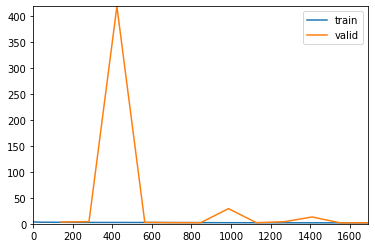

In [ ]:
bigModelNotPretrained.fit_one_cycle(12,max_lr=1e-2) # непосредственное обучение не предобученной большой модели

Как мы видим точность большой не предобученной модели после дообучения достигла 40%. Давайте теперь возьмем предобученную модель и дообучаем ее на нашем датасете

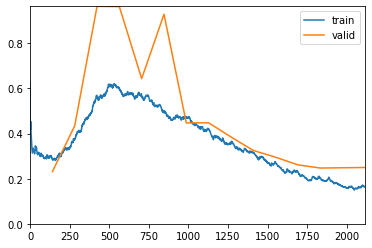

In [ ]:
bigModel.fit_one_cycle(15,max_lr=1e-2) 

Здесь уже качество намного выше и достигает 92.7%

Далее нам надо сформировать класс с нашей новой функцией потерь, которую мы будем оптимизировать. Он нам нужен для возможности обращаться с помощью callback непосредственно при обучении. 

Здесь я постарался реализовать knowledge distillation. То есть взял обученную большую модель и ее выход - это soft targets, те есть полученные значения большой модели на выходе. Далее мы применяем к ним софтмакс, но с температурой T большей единицы. Это дает более мягкое распределение вероятностей для классов. И таким образом, мы хотим приблизить выходные вероятности классов для маленькой модели к получившемуся мягкому распределению веротяностей большой модели. Тем самым мы можем выдернуть, взять больше информации и знаний с большой модели, чем если обучать маленькую модель отдельно от большой. В качестве приближения распределения вероятностей я использую KL дивергенцию - это образно говоря расстояние между распределниями - его я хочу минимизировать (как раз чтобы добиться совпадения вероятностей). Но также еще используется обычная кроссэнтропия между выходным распределением вероятности маленькой модели и граундтрушным распределением вероятностей. Первую и вторую фукнцию потерь, которые я хочу минимизировать я складываю с определенными коэффициентами.   

In [ ]:
class DistillingTheKnowledge(LearnerCallback):
    def __init__(self, distilledModel:Learner, bigModel:Learner, T:float=3.0, alfa:float=0.8):
        super().__init__(distilledModel)
        self.bigModel = bigModel
        self.T, self.alfa = T, alfa
    
    def on_backward_begin(self, last_input, last_output, last_target, **kwargs):
        bigModelOutput = self.bigModel.model(last_input)
        loss = DistillingLoss(last_output, last_target, bigModelOutput, self.T, self.alfa)


        
        return {'last_loss': loss}

def DistillingLoss(output, true_labels, big_model_logit, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output/T, dim=-1), F.softmax(big_model_logit/T, dim=-1).detach()) * (T*T * 2.0 * alpha) + F.cross_entropy(output, true_labels) * (1.0 - alpha) 
    # вот как раз и получившаяся функция, здесь выход и веса большой модели заморожены - используется .detach() а веса маленькой модели обучаются.
    

In [ ]:
#  Маленькая модель - аналогичная первоначальной использующейся в первом эксперименте (мною сконструированная, не Le-Net5). 

distilledModelSequential = nn.Sequential(
    
   nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
   nn.ReLU(), 
   nn.BatchNorm2d(32),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.BatchNorm2d(64),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(256),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(512),
   nn.Dropout(0.25),

   nn.Flatten(),

   nn.Linear(in_features = 4608, out_features=512),
   nn.ReLU(),
   nn.BatchNorm1d(512),
   nn.Dropout(0.5),

   nn.Linear(in_features = 512,out_features=128),
   nn.ReLU(),
   nn.BatchNorm1d(128),
   nn.Dropout(0.5),

   nn.Linear(in_features = 128,out_features=10)
)

In [ ]:
# Инициализация рандомных весов

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
distilledModelSequential.apply(init_weights)
distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy])) # создание модели с помощью fastai

In [ ]:
# Здесь происходят эксперименты с разными значениями температуры и параметра альфа. Я пробовал несколько разных, из того что тестировал эти оказались лучшими.

for T in [2.0, 3.0]:
  for alfa in [0.2]:
    distilledModelSequential.apply(init_weights)
    distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy]))
    distilledModelLearn.model = distilledModelLearn.model.cuda()
    distilledModelLearn.fit_one_cycle(30, 5e-3, callbacks=[DistillingTheKnowledge(distilledModelLearn, bigModel=bigModel, T = T, alfa = alfa)])

Buffered data was truncated after reaching the output size limit.

Как мы можем наблюдать, наша маленькая модель достигает качества примерно в 72.5% на тренировочном датасете. Что более чем на 2% больше по сравнению с такой же моделью, но обученной исключительно на граундтрушных ответах (мы используем всегда одинаковое число эпох для чистоты экспериментов). А это значит, что использование большой модели и ее soft target позволяет подчерпнуть больше информации о датасете и улушить качество классификации сконструированной маленькой модели, хоть и не намного.

Теперь рассмотрим такое же обучение но как маленькую модель используем Le-Net5. Большая модель остается той же.

In [ ]:
class Le_Net5(nn.Module):
    def __init__(self):
        super(Le_Net5, self).__init__()

        # Список слоев использующихся
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5, 5))

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=(4, 4), stride=4)

        self.linear = nn.Linear(1920, 84)
        self.out = nn.Linear(84, 10)
      
    
  
    def Conv1(self, inp):

        t = self.conv1(inp)
        t = self.relu(t)
        t = self.max_pool(t)
        #print(t.shape)
        return t

    def Conv2(self, inp):

        t = self.conv2(inp)
        t = self.relu(t)
        t = self.max_pool(t)
        #print(t.shape)
        return t

    def Conv3(self, inp):

        t = self.conv3(inp)
        t = self.relu(t)
        #print(t.shape)
        return t
    
    def Linear(self, inp):
      t = self.linear(inp)
      t = self.relu(t)

      return t

    def output(self, inp):

      t = self.out(inp)
      return t

    def forward(self, input):

        out = self.Conv1(input)

        x = self.Conv2(out)
        out = self.Conv2(out)

        out += x

        out = self.Conv3(out)

        out = out.view(input.size(0), -1)

        out = self.Linear(out)

        output = self.output(out)

        return output        

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

distilled_model = Le_Net5()

        
distilled_model.apply(init_weights)
distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy])) # создание модели с помощью fastai

In [ ]:
for T in [2.0, 3.0]:
  for alfa in [0.2]:
    distilled_model = Le_Net5()  
    distilled_model.apply(init_weights)
    distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy]))
    distilledModelLearnLeNet.fit_one_cycle(30, 5e-3, callbacks=[DistillingTheKnowledge(distilledModelLearnLeNet, bigModel=bigModel, T = T, alfa = alfa)])

Buffered data was truncated after reaching the output size limit.

Здесь мы видим, что качество достигает 53.1%, что на 1% больше чем если обучать эту модель без использования большой модели. А значит опять же с помощью использования soft target большой модели можно незначительно поднять качество классификации маленькой модели Le-Net5. 

**Отчет**

Как я уже упоминал в начале документа, в первом эксперименте я разрабатываю (конструирую архитектуру, подбираю гиперпараметры) относительно небольшую модель для классификации и обучаю ее. Запоминаю качество распознавания полученной модели. Также в этом эксперименте я обучаю известную модель Le-Net5.

Далее я использую большую модель. На нее как раз будет опираться маленькая модель (маленькая модель - distilled model).

Маленькие модели состоят из тех же слоев и гиперпараметров как и модели из первого эксперимента. Но теперь при обучении мы будем использовать не только реальные правильные ответы, но и ответы soft target - это более сглаженное распределедение вероятностей хорошо обученной большой модели. То есть для формирования вероятностного распределения большой модели для классов классификации используется не обычный совтмакс, а софтмакс с повышенной температурой, для обеспечения мягкости распределения.

То есть теперь, маленькая модель тренируется таким образом, чтобы конечные распределения вероятностей distilled model и большой модели были максимально близки. Это обеспечивается как раз KL дивергенцией - образно говоря мера расстояния между распределениями - ее мы устремляем к нулю, то есть эта KL дивергенция может играть роль функции потерь, которую мы минимизируем. Но также мы минимизируем вторую функцию потерь - обычную кроссэнтропию между выходом маленькой модели и реальными правильными ответами. Эти две функции складываются с определенными коэффицентами и общая получившаяся функция минимизируется.

**Результаты**

В данных экспериментах мы показали, что с помощью результатов большой модели можно увеличить качество распознавания маленькой модели. Причем мы проводили исследования для двух разных маленьких моделей - мною разработанной и Le-Net5. Конкретно для датасета imagewoof прирост качества составил около 2% достоверности для первой модели и 1% для второй. В первом эксперименте, без использования большой модели, качество достигло 70% и 52.1%, а во втором эксперименте с использованием большой модели - качество достигло 72% и 53.1%. 

Я пытался перебрать как можно больше значений параметра температуры T и alpha, но в условиях ограниченного времени перебрал конечно не все, что хотел. Если загрузить полный грамотный подбор этих гиперпараметров я думаю качество можно еще улучшить на несколько процентов. 

P.S. Конечно идеально было бы также провести несколько итераций обучения каждого случая и после этого усреднить результаты (для статистической достоверности), но в условиях ограниченного времени это не выполняется. Но при проведении экспериментов я получал примерно одинаковые результаты равные описанным выше. Поэтому можно считать, что результаты статистически верны. 